Found 962 files belonging to 4 classes.
Using 770 files for training.
Found 962 files belonging to 4 classes.
Using 192 files for validation.
Checkpoint: mobileNet_V1.keras
Loss: 0.4213
Accuracy: 0.8281
Precision: 0.8891
Recall: 0.6706
F1 Score: 0.7025
----------------------------------------
Checkpoint: mobileNet_V2.keras
Loss: 0.3290
Accuracy: 0.9062
Precision: 0.8196
Recall: 0.6977
F1 Score: 0.6799
----------------------------------------


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Checkpoint: mobileNet_V3_Small.keras
Loss: 0.4527
Accuracy: 0.8281
Precision: 0.6851
Recall: 0.7083
F1 Score: 0.6961
----------------------------------------


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Checkpoint: mobileNetV3_Large.keras
Loss: 0.3262
Accuracy: 0.9062
Precision: 0.6072
Recall: 0.6625
F1 Score: 0.6329
----------------------------------------
Checkpoint: efficientNet_B0.keras
Loss: 0.3019
Accuracy: 0.9531
Precision: 0.8833
Recall: 0.8625
F1 Score: 0.8695
----------------------------------------


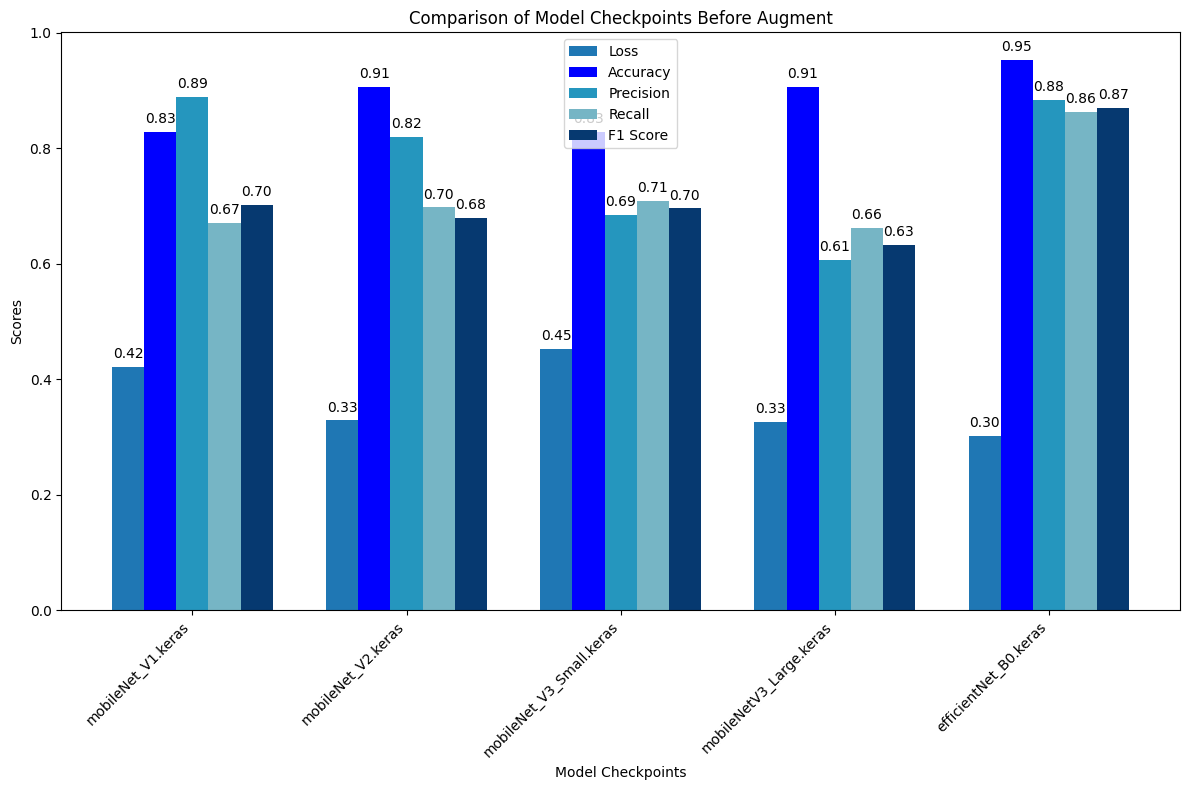

In [20]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import os
import matplotlib.pyplot as plt

# Đường dẫn tới các checkpoint mô hình
checkpoint_files = [
    'mobileNet_V1.keras',
    'mobileNet_V2.keras',
    'mobileNet_V3_Small.keras',
    'mobileNetV3_Large.keras',
    'efficientNet_B0.keras'
]

# Đường dẫn tới dataset
DATASET_DIR = 'dataset'
data_dir = os.path.join(DATASET_DIR)

BATCH_SIZE = 64
IMG_SIZE = (224, 224)

# Tạo dataset cho training và validation
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, 
    subset="training",    
    seed=123,              
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  
    subset="validation",   
    seed=123,              
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

# Tính số batch trong validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)

# Tạo test dataset từ validation dataset (lấy 20% dữ liệu)
test_dataset = validation_dataset.take(max(1, val_batches // 5))

# Cập nhật lại validation_dataset bằng cách bỏ qua phần đã lấy cho test
validation_dataset = validation_dataset.skip(max(1, val_batches // 5))

# Danh sách lưu kết quả
results = []

# Đánh giá mô hình trên tập test
for checkpoint_file in checkpoint_files:
    # Load mô hình
    model = load_model(checkpoint_file)

    # Đánh giá mô hình trên test dataset
    loss, accuracy = model.evaluate(test_dataset, verbose=0)
    
    # Lấy batch ảnh và nhãn để dự đoán
    image_batch, label_batch = next(iter(test_dataset))
    predictions_probs = model.predict_on_batch(image_batch)
    predictions = np.argmax(predictions_probs, axis=1)
    labels = np.argmax(label_batch, axis=1)

    # Tính toán các chỉ số
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    f1 = f1_score(labels, predictions, average='macro')

    # Lưu kết quả
    results.append({
        'checkpoint': checkpoint_file,
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

    # In kết quả đánh giá cho từng checkpoint
    print(f"Checkpoint: {checkpoint_file}")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * 40)

# Vẽ biểu đồ so sánh
model_names = [result['checkpoint'] for result in results]
losses = [result['loss'] for result in results]
accuracies = [result['accuracy'] for result in results]
precisions = [result['precision'] for result in results]
recalls = [result['recall'] for result in results]
f1_scores = [result['f1_score'] for result in results]

x = np.arange(len(model_names))  # Vị trí của các cột
width = 0.15  # Độ rộng của mỗi cột

fig, ax = plt.subplots(figsize=(12, 8))

# Vẽ các cột cho từng chỉ số
bar1 = ax.bar(x - 2 * width, losses, width, label='Loss', color='#1f77b4')
bar2 = ax.bar(x - width, accuracies, width, label='Accuracy', color='blue')
bar3 = ax.bar(x, precisions, width, label='Precision', color='#2596be')
bar4 = ax.bar(x + width, recalls, width, label='Recall', color='#76b5c5')
bar5 = ax.bar(x + 2 * width, f1_scores, width, label='F1 Score', color='#063970')


# Gắn tên các mô hình vào trục x
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha="right")

# Thêm tiêu đề và nhãn
ax.set_xlabel("Model Checkpoints")
ax.set_ylabel("Scores")
ax.set_title("Comparison of Model Checkpoints Before Augment")
ax.legend()

# Hiển thị giá trị trên mỗi cột
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)
add_labels(bar4)
add_labels(bar5)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

Found 11544 files belonging to 4 classes.
Using 9236 files for training.
Found 11544 files belonging to 4 classes.
Using 2308 files for validation.
Checkpoint: mobileNet_V1_Aug.keras
Loss: 0.0141
Accuracy: 0.9888
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
----------------------------------------
Checkpoint: mobileNet_V2_Aug.keras
Loss: 0.0244
Accuracy: 0.9955
Precision: 0.9936
Recall: 0.9773
F1 Score: 0.9848
----------------------------------------
Checkpoint: mobileNet_V3_Small_Aug.keras
Loss: 0.0186
Accuracy: 0.9955
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
----------------------------------------
Checkpoint: mobileNetV3_Large_Aug.keras
Loss: 0.0059
Accuracy: 0.9955
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
----------------------------------------
Checkpoint: efficientNet_B0_aug.keras
Loss: 0.0090
Accuracy: 0.9978
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
----------------------------------------


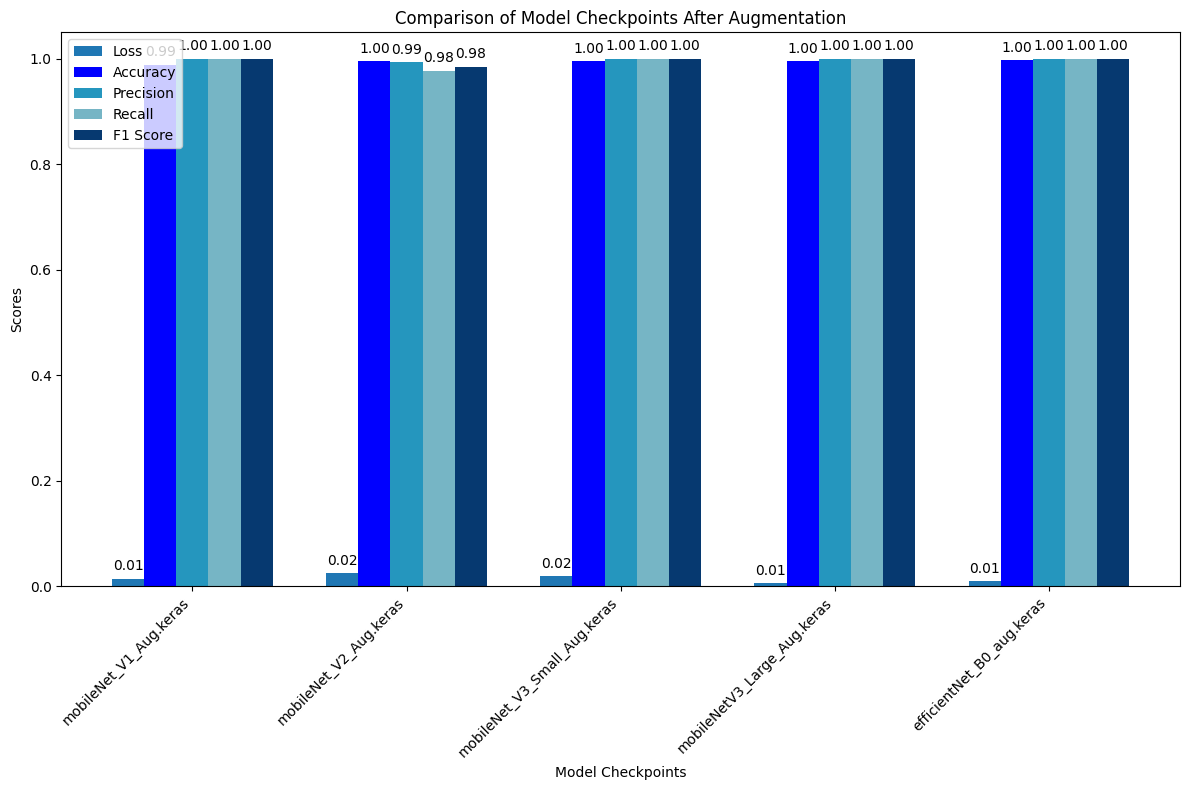

In [19]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import os
import matplotlib.pyplot as plt

# Đường dẫn tới các checkpoint mô hình
checkpoint_files = [
    'mobileNet_V1_Aug.keras',
    'mobileNet_V2_Aug.keras',
    'mobileNet_V3_Small_Aug.keras',
    'mobileNetV3_Large_Aug.keras',
    'efficientNet_B0_aug.keras'
]

# Đường dẫn tới dataset
DATASET_DIR = 'aug_dataset'
data_dir = os.path.join(DATASET_DIR)

BATCH_SIZE = 64
IMG_SIZE = (224, 224)

# Tạo dataset cho training và validation
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, 
    subset="training",    
    seed=123,              
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  
    subset="validation",   
    seed=123,              
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

# Tính số batch trong validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)

# Tạo test dataset từ validation dataset (lấy 20% dữ liệu)
test_dataset = validation_dataset.take(max(1, val_batches // 5))

# Cập nhật lại validation_dataset bằng cách bỏ qua phần đã lấy cho test
validation_dataset = validation_dataset.skip(max(1, val_batches // 5))

# Danh sách lưu kết quả
results = []

# Đánh giá mô hình trên tập test
for checkpoint_file in checkpoint_files:
    # Load mô hình
    model = load_model(checkpoint_file)

    # Đánh giá mô hình trên test dataset
    loss, accuracy = model.evaluate(test_dataset, verbose=0)
    
    # Lấy batch ảnh và nhãn để dự đoán
    image_batch, label_batch = next(iter(test_dataset))
    predictions_probs = model.predict_on_batch(image_batch)
    predictions = np.argmax(predictions_probs, axis=1)
    labels = np.argmax(label_batch, axis=1)

    # Tính toán các chỉ số
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    f1 = f1_score(labels, predictions, average='macro')

    # Lưu kết quả
    results.append({
        'checkpoint': checkpoint_file,
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

    # In kết quả đánh giá cho từng checkpoint
    print(f"Checkpoint: {checkpoint_file}")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * 40)

# Vẽ biểu đồ so sánh
model_names = [result['checkpoint'] for result in results]
losses = [result['loss'] for result in results]
accuracies = [result['accuracy'] for result in results]
precisions = [result['precision'] for result in results]
recalls = [result['recall'] for result in results]
f1_scores = [result['f1_score'] for result in results]

x = np.arange(len(model_names))  # Vị trí của các cột
width = 0.15  # Độ rộng của mỗi cột

fig, ax = plt.subplots(figsize=(12, 8))

# Vẽ các cột cho từng chỉ số
bar1 = ax.bar(x - 2 * width, losses, width, label='Loss', color='#1f77b4')
bar2 = ax.bar(x - width, accuracies, width, label='Accuracy', color='blue')
bar3 = ax.bar(x, precisions, width, label='Precision', color='#2596be')
bar4 = ax.bar(x + width, recalls, width, label='Recall', color='#76b5c5')
bar5 = ax.bar(x + 2 * width, f1_scores, width, label='F1 Score', color='#063970')


# Gắn tên các mô hình vào trục x
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha="right")

# Thêm tiêu đề và nhãn
ax.set_xlabel("Model Checkpoints")
ax.set_ylabel("Scores")
ax.set_title("Comparison of Model Checkpoints After Augmentation")
ax.legend()

# Hiển thị giá trị trên mỗi cột
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)
add_labels(bar4)
add_labels(bar5)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()